In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from utils import plot_sparsity_matrix,weight_histograms,set_all_seeds
from dataset import get_mnist_loader
from pruning import threshold_prune,save_sparse_weights,count_nonzero_weights
import datetime
import numpy as np

# Dataset

# Configuration

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))])

BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-3
MU = 0.9
LAMBDA = 1e-2
S = 2

SEED = 42
CLASSES = [0,1,2,3,4,5,6,7,8,9]
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Try to get GPU device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
checkpoint_path = '../checkpoints/'
set_all_seeds(SEED)

trainloader,testloader = get_mnist_loader(transform,BATCH_SIZE)

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



Print images from dataset and their labels

torch.Size([128, 1, 28, 28]) torch.Size([128])
1 2 8 5


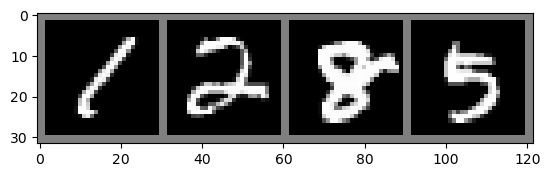

In [3]:
import matplotlib.pyplot as plt
from utils import imshow

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

# LeNet-300-100

LeNet-300-100 is a Fully-Connected neural network, presented in [[1](#1)].
It is composed by two hidden layers, with respectively 300 and 100 units.

In [4]:
from models.lenet import LeNet300

net = LeNet300(10)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

cuda:0


LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [5]:
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as sched
from train import MyMultiStepLR

loss_fn = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=LR,momentum=MU, weight_decay=LAMBDA)

In [6]:

from torch.utils.tensorboard import SummaryWriter
from train import training_loop

writer = SummaryWriter('runs/mnist/lenet300-100/%s' % TIMESTAMP)

loss, train_acc, val_acc = training_loop(EPOCHS,net,optimizer,device,trainloader,testloader,loss_fn,100,
                                         None,'checkpoints/mnist-lenet300-100.pth',writer)

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'lambda':LAMBDA,'momentum':MU},{'loss':np.array(loss).min(),'train_accuracy':np.array(train_acc).max(),'validation accuracy':np.array(val_acc).max(),'compression':1})
writer.add_scalar('total parameters',count_nonzero_weights(net))

***Epoch: 001/020 | Batch:0000/0469 | Loss: 2.299
***Epoch: 001/020 | Batch:0100/0469 | Loss: 2.109
***Epoch: 001/020 | Batch:0200/0469 | Loss: 1.716
***Epoch: 001/020 | Batch:0300/0469 | Loss: 1.208
***Epoch: 001/020 | Batch:0400/0469 | Loss: 0.843
***Epoch: 001/020 | Train. Acc.: 81.440% | Loss: 0.743
Epoch: 001/020 | Train accuracy: 81.44% | Validation accuracy: 81.81% | Train loss: 0.743| Validation loss: 0.726| Best Validation (Ep. 000): -inf%


RuntimeError: Parent directory checkpoints does not exist.

In [ ]:
# visualization loss
plt.plot(loss)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(train_acc,color = "red")
plt.plot(val_acc,color = "blue")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [ ]:
from pruning import threshold_prune

net = LeNet300(10)
net.load_state_dict(torch.load('checkpoints/mnist-lenet300-100.pth'))

cf = threshold_prune(net,S)

writer = SummaryWriter('runs/mnist/lenet300-100-pruned/%s' % TIMESTAMP)

writer.add_scalar('compression factor',cf)
weight_histograms(writer,None,net)

plot_sparsity_matrix(net)
torch.save(net.state_dict(),'checkpoints/mnist-lenet300-100-pruned.pth')

We can see that the fc1 layer is divided in 28 vertical bands, whose width is 28, corresponding to the $28 \times 28$ input pixel.
As stated in [[2](#2)], network pruning detects visual attention regions: the colored regions, correspond to non-zero parameters, are more dense in the center of the image, since the digits are written in the center.

In [ ]:
from train import evaluate

net.load_state_dict(torch.load('checkpoints/mnist-lenet300-100-pruned.pth'))
net.to(device)

valid_acc, valid_loss = evaluate(net, testloader, device, loss_fn)

print('Accuracy after pruning: %.3f%% | Loss: %.3f' % (
        valid_acc, valid_loss))

writer = SummaryWriter('runs/mnist/lenet300-100-retrained/%s' % TIMESTAMP)
optimizer = optim.SGD(net.parameters(), lr=LR,momentum=MU,weight_decay=LAMBDA)


loss, train_acc, val_acc = training_loop(EPOCHS,net,optimizer,device,trainloader,testloader,loss_fn,100,
                                         None,'checkpoints/mnist-lenet300-100-retrained.pth',writer)

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'lambda':LAMBDA,'momentum':MU},{'loss':np.array(loss).min(),'train_accuracy':np.array(train_acc).max(),'validation accuracy':np.array(val_acc).max(),'compression':cf})

torch.save(net.state_dict(),'checkpoints/mnist-lenet300-100-finetuned.pth')

plot_sparsity_matrix(net)

# LeNet-5

![Lenet5](./assets/lenet-5_1.jpg "LeNet 5")

The input is a $32 \times 32$ image, since [[2](#2)] found desirable to have distinctive features of each character in the center of the receptive field of the highest-level feature detectors.

- C1 is a convolutional layer with 6 feature maps and a kernel of $5 \times 5$.
- S

Images need to be rescaled to size 32x32 as described in LeCun et al. 1998

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5)),
     transforms.Resize(32)])
# Load datasets
trainloader,testloader = get_mnist_loader(transform,BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

In [ ]:
from models.lenet import LeNet5

net = LeNet5(10)
# Try to get GPU device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

In [ ]:
from train import training_loop

loss_fn = F.cross_entropy
optimizer = optim.SGD(net.parameters(), lr=LR,momentum=MU,weight_decay=LAMBDA)

lrs = MyMultiStepLR({0:5e-4,2:2e-4,5:1e-4,8:5e-5,12:1e-5})
# scheduler = sched.LambdaLR(optimizer,  lrs.get_lr,last_epoch=-1,verbose=True)

writer = SummaryWriter('runs/mnist/lenet-5/%s' % TIMESTAMP)

loss, train_acc, val_acc = training_loop(EPOCHS,net,optimizer,device,trainloader,testloader,loss_fn,100,None
                                         ,'checkpoints/mnist-lenet5.pth',writer)

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'lambda':LAMBDA,'momentum':MU},{'loss':np.array(loss).min(),'train_accuracy':np.array(train_acc).max(),'validation accuracy':np.array(val_acc).max(),'compression':1})

writer.add_scalar('total parameters',count_nonzero_weights(net))

In [ ]:
# visualization loss
plt.plot(loss)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(train_acc,color = "red")
plt.plot(val_acc,color = "blue")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

In [ ]:
net = LeNet5(10)
net.load_state_dict(torch.load('checkpoints/mnist-lenet5.pth'))
net.to(device)

cf = threshold_prune(net,S)

writer = SummaryWriter('runs/mnist/lenet5-pruned/%s' % TIMESTAMP)

writer.add_scalar('compression factor',cf)
weight_histograms(writer,None,net)
torch.save(net.state_dict(),'checkpoints/mnist-lenet5-pruned.pth')

valid_acc, valid_loss = evaluate(net, testloader, device, loss_fn)

print('Accuracy after pruning: %.3f%% | Loss: %.3f' % (
        valid_acc, valid_loss))

optimizer = optim.SGD(net.parameters(), lr=LR,momentum=MU,weight_decay=LAMBDA)
writer = SummaryWriter('runs/mnist/lenet5-retrained/%s' % TIMESTAMP)

loss, train_acc, val_acc = training_loop(EPOCHS,net,optimizer,device,trainloader,testloader,loss_fn,100,
                                         None,'checkpoints/mnist-lenet5-retrained.pth',writer)

torch.save(net.state_dict(),'checkpoints/mnist-lenet5-finetuned.pth')

writer.add_hparams({'epochs':EPOCHS,'learning rate':LR,'lambda':LAMBDA,'momentum':MU},{'loss':np.array(loss).min(),'train_accuracy':np.array(train_acc).max(),'validation accuracy':np.array(val_acc).max(),'compression':cf})

In [ ]:
weight_histograms(writer,None,net)

In [ ]:

# can duplicate parameters if shared
from models.lenet import LeNet300
import torch
import os

from quantization import quantize
from pruning import threshold_prune,apply_prune

os.environ["OMP_NUM_THREADS"] = '1'

net = LeNet300(10)
net.load_state_dict(torch.load('checkpoints/mnist-lenet300-100.pth'))

threshold_prune(net,2)
apply_prune(net)

quantize(net,5)


# References
<a id="1">[1]</a> LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.
<a id="2">[2]</a> Han, Song, et al. "Learning both weights and connections for efficient neural network." Advances in neural information processing systems 28 (2015).